# A/B testing with Bayesian Statistics and pymc3
In this notebook I am using pymc3 to perform an A/B test on three different configurations of a university library website, the configurations are displayed below. The variation is the title of one of the links. I will use pymc3, based on bayesian probabliy to see if any of the cnahges can produce statsitically significant results in either a positive or negative mannner.
The data has been taken from http://scholarworks.montana.edu/xmlui/handle/1/3507

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
%matplotlib inline

In [24]:
## Loading the data
Data_A=pd.read_csv('../../CrazyEgg/Homepage Version 1 - Interact, 5-29-2013/Element list Homepage Version 1 - Interact, 5-29-2013.csv')
Data_B=pd.read_csv('../../CrazyEgg/Homepage Version 2 - Connect, 5-29-2013/Element list Homepage Version 2 - Connect, 5-29-2013.csv')
Data_C=pd.read_csv('../../CrazyEgg/Homepage Version 3 - Learn, 5-29-2013/Element list Homepage Version 3 - Learn, 5-29-2013.csv')
Data_D=pd.read_csv('../../CrazyEgg/Homepage Version 4 - Help, 5-29-2013/Element list Homepage Version 4 - Help, 5-29-2013.csv')
Data_E=pd.read_csv('../../CrazyEgg/Homepage Version 5 - Services, 5-29-2013/Element list Homepage Version 5 - Services, 5-29-2013.csv')

In [25]:
## Rename a poorly named column
Data_A.rename(columns={'No. clicks':'clicks'},inplace=True)
Data_B.rename(columns={'No. clicks':'clicks'},inplace=True)
Data_C.rename(columns={'No. clicks':'clicks'},inplace=True)
Data_D.rename(columns={'No. clicks':'clicks'},inplace=True)
Data_E.rename(columns={'No. clicks':'clicks'},inplace=True)

In [26]:
Data_B.head(10)

,Element ID,Tag name,Name,clicks,Visible?,Snapshot information
0,74,a,FIND,502,True,Homepage Version 2 - Connect • http://www....
1,66,input,s.q,357,True,created 5-29-2013 • 20 days 7 hours 34 min...
2,72,a,lib.montana.edu/find/,171,True,NaN
3,133,area,Montana State University Libraries - Home,83,False,NaN
4,103,a,Hours,74,True,NaN
5,83,a,REQUEST,57,True,NaN
6,92,a,CONNECT,53,True,NaN
7,67,button,Search,47,True,NaN
8,81,a,lib.montana.edu/request/,31,True,NaN
9,101,a,News,31,True,NaN


In [27]:
## I am only interested in the number of clicks that are used on the website to go to various links, and specifically 
## the proporations of these that are used on the varied link.
Data_A=Data_A[Data_A['Tag name']=='a']
Data_B=Data_B[Data_B['Tag name']=='a']
Data_C=Data_C[Data_C['Tag name']=='a']
Data_D=Data_D[Data_D['Tag name']=='a']
Data_E=Data_E[Data_E['Tag name']=='a']

In [28]:
## I will now sum all of the clicks that have taken place in each of the sets of oberseved data, and the number of 
## clicks directed at the links under investigation.
Total_Clicks_A=Data_A.clicks.sum()
Test_Clicks_A=Data_A[Data_A.Name=='INTERACT'].clicks
Total_Clicks_B=Data_B.clicks.sum()
Test_Clicks_B=Data_B[Data_B.Name=='CONNECT'].clicks
Total_Clicks_C=Data_C.clicks.sum()
Test_Clicks_C=Data_C[Data_C.Name=='LEARN'].clicks
Total_Clicks_D=Data_D.clicks.sum()
Test_Clicks_D=Data_D[Data_D.Name=='HELP'].clicks
Total_Clicks_E=Data_E.clicks.sum()
Test_Clicks_E=Data_E[Data_E.Name=='SERVICES'].clicks

In [29]:
## The proportion of test clicks to total clicks is extremely low, I expect this will lead to results that are not 
## very signifcant due to the relative size.
print Test_Clicks_A/Total_Clicks_A
print Test_Clicks_B/Total_Clicks_B

9    0.025751
Name: clicks, dtype: float64
6    0.051257
Name: clicks, dtype: float64


In [30]:
## Here I am converting the number of clicks into a binary numpy array, with all the positive clicks as 1s and all 
## of the other clicks as 0s.
Bin_Data_A = np.r_[[0] * (Total_Clicks_A-Test_Clicks_A), [1] * Test_Clicks_A]
Bin_Data_B = np.r_[[0] * (Total_Clicks_B-Test_Clicks_B), [1] * Test_Clicks_B]
Bin_Data_C = np.r_[[0] * (Total_Clicks_C-Test_Clicks_C), [1] * Test_Clicks_C]
Bin_Data_D = np.r_[[0] * (Total_Clicks_D-Test_Clicks_D), [1] * Test_Clicks_D]
Bin_Data_E = np.r_[[0] * (Total_Clicks_E-Test_Clicks_E), [1] * Test_Clicks_E]

In [31]:
## I will now initialise the model, and create uniform prior distirbutions for each of the scenarios. 
model=pm.Model()
with model:
    p_A = pm.Uniform('p_A', lower=0, upper=1)
    p_B = pm.Uniform('p_B', lower=0, upper=1)
    p_C = pm.Uniform('p_C', lower=0, upper=1)
    p_D = pm.Uniform('p_D', lower=0, upper=1)
    p_E = pm.Uniform('p_E', lower=0, upper=1)

Applied interval-transform to p_A and added transformed p_A_interval_ to model.
Applied interval-transform to p_B and added transformed p_B_interval_ to model.
Applied interval-transform to p_C and added transformed p_C_interval_ to model.
Applied interval-transform to p_D and added transformed p_D_interval_ to model.
Applied interval-transform to p_E and added transformed p_E_interval_ to model.


In [32]:
## Using the deterministic function I have created Delta values, that calcualte the difference between the base 
## and test scenarios.
with model:
        delta_B = pm.Deterministic('Delta_B', p_B - p_A)
        delta_C = pm.Deterministic('Delta_C', p_C - p_A)
        delta_D = pm.Deterministic('Delta_D', p_D - p_A)
        delta_E = pm.Deterministic('Delta_E', p_E - p_A)

In [33]:

with model:
    obs_A = pm.Bernoulli("obs_A", p_A,Bin_Data_A, observed = True)
    obs_B = pm.Bernoulli("obs_B", p_B,Bin_Data_B, observed = True)
    obs_C = pm.Bernoulli("obs_C", p_C,Bin_Data_C, observed = True)
    obs_D = pm.Bernoulli("obs_D", p_D,Bin_Data_D, observed = True)
    obs_E = pm.Bernoulli("obs_E", p_E,Bin_Data_E, observed = True)

In [34]:
with model:
    trace = pm.sample(25000, njobs=4)

burned_trace=trace[10000:]

Assigned NUTS to p_A_interval_
Assigned NUTS to p_B_interval_
Assigned NUTS to p_C_interval_
Assigned NUTS to p_D_interval_
Assigned NUTS to p_E_interval_
100%|██████████| 25000/25000 [01:36<00:00, 259.32it/s]


In [36]:
burned_trace[0]

{'Delta_B': -0.66120468133305654,
 'Delta_C': 0.17881877792876388,
 'Delta_D': -0.056578866404849881,
 'Delta_E': -0.35818375504808575,
 'p_A': 0.81811713097704353,
 'p_A_interval_': 1.5036426151598326,
 'p_B': 0.15691244964398696,
 'p_B_interval_': -1.6813828040838252,
 'p_C': 0.99693590890580741,
 'p_C_interval_': 5.7849355020324786,
 'p_D': 0.76153826457219365,
 'p_D_interval_': 1.161131561019602,
 'p_E': 0.45993337592895778,
 'p_E_interval_': -0.16061086580072925}

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.hist(burned_trace["p_A"], bins=70, normed=True)
ax1.set_title("Posterior distribution for the \n mean of the APM of 19yo")
ax1.set_xlim([0,1])
ax2.hist(burned_trace["p_B"], bins=70, normed=True)
ax2.set_title("Posterior distribution for the \n mean of the APM of 26yo")
ax2.set_xlim([0,1])
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12911cb90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x12109bd90>], dtype=object)

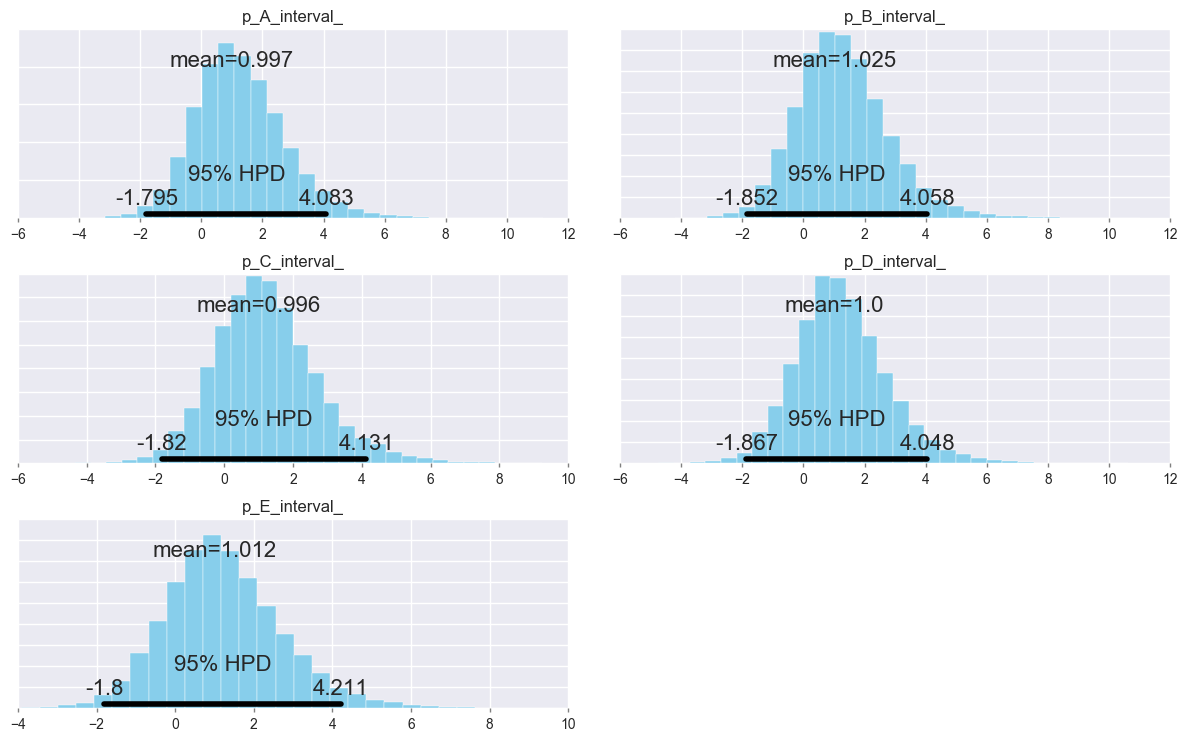

In [35]:
pm.plot_posterior(burned_trace,
                  varnames=['p_A_interval_', 'p_B_interval_','p_C_interval_','p_D_interval_','p_E_interval_'],
                  color='#87ceeb')

In [37]:
print "Probability site A is BETTER than site B: %.3f" %(burned_trace["Delta_B"] < 0).mean()
print "Probability site A is WORSE than site B: %.3f" %(burned_trace["Delta_B"] > 0).mean()

Probability site A is BETTER than site B: 0.495
Probability site A is WORSE than site B: 0.505


In [38]:
print "Probability site A is BETTER than site C: %.3f" %(burned_trace["Delta_C"] < 0).mean()
print "Probability site A is WORSE than site C: %.3f" %(burned_trace["Delta_C"] > 0).mean()

Probability site A is BETTER than site C: 0.500
Probability site A is WORSE than site C: 0.500


In [39]:
print "Probability site A is BETTER than site D: %.3f" %(burned_trace["Delta_D"] < 0).mean()
print "Probability site A is WORSE than site D: %.3f" %(burned_trace["Delta_D"] > 0).mean()

Probability site A is BETTER than site D: 0.497
Probability site A is WORSE than site D: 0.503


In [40]:
print "Probability site A is BETTER than site E: %.3f" %(burned_trace["Delta_E"] < 0).mean()
print "Probability site A is WORSE than site E: %.3f" %(burned_trace["Delta_E"] > 0).mean()

Probability site A is BETTER than site E: 0.496
Probability site A is WORSE than site E: 0.504
